# 프로젝트 8: 네이버 영화리뷰 감성분석 도전하기

### 라이브러리 버전 확인

In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.6.0


### 1. 데이터 준비와 확인

In [3]:
import pandas as pd

from konlpy.tag import Mecab  # Mecab : 일본어 형태소 분석기
import numpy as np
from collections import Counter

from tensorflow import keras
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re  # 정규 표현식

from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

In [4]:
import pandas as pd

train_data = pd.read_table('/content/drive/MyDrive/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
# 훈련 데이터와 테스트 데이터의 리뷰 개수 확인
print('훈련 데이터의 형태 : ', train_data.shape)
print('테스트 데이터의 형태 : ', test_data.shape)

훈련 데이터의 형태 :  (150000, 3)
테스트 데이터의 형태 :  (50000, 3)


### 2. 데이터로더 구성

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

#### 데이터 전처리


* 데이터의 중복 제거
* NaN 결측치 제거

In [6]:
# 중복하지 않은 데이터의 개수
train_data[['document', 'label']].nunique()  # nunique는 선택된 축에 대해서 고유한 요소의 수를 구하는 메서드

document    146182
label            2
dtype: int64

학습용 데이터는 150,000-146812 = 3,818개의 리뷰가 중복되고, 레이블은 0과 1만 있으므로 중복하지 않는 개수는 2개이다.

In [7]:
# 정규 표현식을 이용하여 한글, 숫자, 공백을 제외하고 모두 제거한다.
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")

train_data[:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [8]:
# train_data에 document 열에 빈 값을 가진 행이 있다면 Null 값으로 변경
train_data['document'].replace('', np.nan, inplace=True)

# 다시 한 번 Null 값이 존재하는지 확인
train_data.isnull().sum()

id            0
document    694
label         0
dtype: int64

In [9]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
668,1600635,NaN,0
1559,6918082,NaN,1
1840,7095375,NaN,1
2073,384233,NaN,1
2648,423224,NaN,1


In [10]:
train_data = train_data.dropna(how='any')

print('전처리 후 학습용 데이터 개수 : ', len(train_data))

전처리 후 학습용 데이터 개수 :  149306


In [11]:
# 테스트 데이터도 정규 표현식을 이용하여 한글, 숫자, 공백을 제외하고 모두 제거한다. 
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9 ]", "")

# test_data에 document 열에 빈 값을 가진 행이 있다면 Null 값으로 변경한다.
test_data['document'].replace('', np.nan, inplace=True)

# NaN은 아무런 의미가 없는 데이터 이므로 제거한다.
test_data = test_data.dropna(how = 'any')

print('전처리 후 테스트용 데이터 개수 :', len(test_data))

전처리 후 테스트용 데이터 개수 : 49773


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


#### 2-2.토큰화, 불용어(Stopwords) 제거, word_to_index

* 한국어를 토근화할 때, 형태소 분석기를 사용한다.
* 자연어 처리를 하기 위해서 긴 텍스트를 단어별로 쪼개는 작업이다.
* 토큰화 과정에서 불용어를 제거한다.
* 토큰화된 단어들을 인덱스로 변환한다.

In [12]:
# from konlpy.tag import Mecab를 위해 설치한다.
!%%bash
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev
!pip3 install JPype1
!pip3 install konlpy
!%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"
!%%bash
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
!pip3 install /tmp/mecab-python-0.996

/bin/bash: line 0: fg: no job control
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading packa

In [13]:
# 형태소 분석기 객체 생성
tokenizer = Mecab()

# 불용어 리스트(불용어란 문장 내에서 빈번하게 발생하여 의미를 부여하기 어려운 단어)
stopwords = ['의', '가', '이', '은', '들','는','좀','잘','강','과','도', '를', '으로','자', '에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 학습용 데이터에서 document 열에서 중복 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    # 학습용 데이터에서 Null 값이 존재하는 행 제거
    train_data = train_data.dropna(how = 'any')
    # 테스트용 데이터에서 document 열에서 중복 데이터 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # 테스트용 데이터에서 Null 값이 존재하는 행 제거
    test_data = test_data.dropna(how = 'any')

    # 한국어 토크나이저로 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)  # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]  # 불용어 제거
        X_test.append(temp_X)

    # 사전 작성
    words = np.concatenate(X_train).tolist()  #.tolist() : array를 list로 변경
    counter = Counter(words)                  # collection 모듈의 Counter 클래스로 데이터의 개수 확인
    counter = counter.most_common(10000-4)    # most_common() : 데이터의 개수가 많은 순으로 정렬된 배열 리턴
    vocab = ['<PAD>','<BOS>','<UNK>','<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    # word_to_index
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        # wordlist 에 있는 word에 대해서 만약에 wrod가 word_to_index에 존재하면 인덱스 값을, 존재하지 않으면 <UNK>를 인덱스로 반환  
    
    X_train = list(map(wordlist_to_indexlist, X_train)) # X_train 대상으로 worldlist_to_indexlist 함수를 수행하여 리스트로 반환
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [14]:
print("훈련 데이터 개수: {}, 테스트 데이터 개수: {}".format(len(X_train), len(X_test)))

훈련 데이터 개수: 143856, 테스트 데이터 개수: 48498


In [15]:
# key = index, value = word로 변경
index_to_word = {index:word for word, index in word_to_index.items()}
print(len(word_to_index))

10000


#### 2-3. 텍스를 숫자로 (encoding), 숫자를 텍스트로 (decoding)

In [16]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수이다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 한다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수이다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수이다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수이다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3. 모델 구성을 위한 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

#### 데이터셋 내 문장 길이 분포

In [17]:
# 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  14.108799401104214
문장길이 최대 :  84
문장길이 표준편차 :  11.58840117345961


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


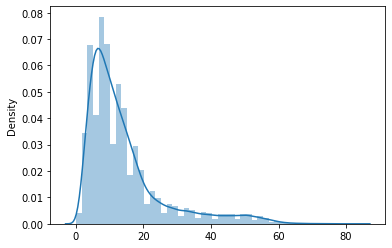

In [18]:
# 문장 길이 분포 시각화
sns.distplot(num_tokens)

위에서 문장길이 평균이 약 14.07이 나왔다. 시각화를 통해 약 14에서 밀도가 높은 것을 확인할 수 있다.

In [19]:
# 최대 길이를 (평균 + 3*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

pad_sequences maxlen :  48
전체 문장의 0.9704607130602951%가 maxlen 설정값 이내에 포함됩니다.


In [20]:
# keras.preprocessing.sequence.pad_sequence를 활용한 패딩 추가한다.
# 문장의 길이가 maxlen보다 짧은 문장에 <PAD>를 앞부분에 추가한다.
# RNN은 입력데이터가 순차적으로 처리되므로 'pre'를 사용한다.
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=maxlen)

print('shape of X_train: ', X_train.shape)
print('shape of X_test: ', X_test.shape)

shape of X_train:  (143856, 48)
shape of X_test:  (48498, 48)


### 4. 모델 구성 및 validiation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

#### 4-1. train set, validation set 구성

In [21]:
# 훈련 데이터의 80% 개수
print('훈련 데이터의 80% 개수: ', int(X_train.shape[0]*0.8))

훈련 데이터의 80% 개수:  115084


In [22]:
# train data set에서 80:20의 비율로 trian과 validation을 분리한다.
# RNN에서는 순서가 중요하므로 shuffle은 진행하지 않는다.
# train set
partial_X_train = X_train[:int(X_train.shape[0]*0.8)]
partial_y_train = y_train[:int(y_train.shape[0]*0.8)]

# validation set
X_valid = X_train[int(X_train.shape[0]*0.8):]
y_valid = y_train[int(X_train.shape[0]*0.8):]

print('partial_X_train : ', partial_X_train.shape)
print('partial_y_train : ', partial_y_train.shape)
print('X_valid : ', X_valid.shape)
print('y_valid : ', y_valid.shape)

partial_X_train :  (115084, 48)
partial_y_train :  (115084,)
X_valid :  (28772, 48)
y_valid :  (28772,)


#### 4-2-1. LSTM 모델

In [259]:
vocab_size = 10000  # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원

model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(128))                     # RNN에서 가장 널리 사용하는 LSTM 레이어 사용                   # LSTM 모델을 발전시킨 모델  
model1.add(keras.layers.Dense(16, activation='relu'))
model1.add(keras.layers.Dense(1,activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 200)         2000000   
                                                                 
 lstm_6 (LSTM)               (None, 128)               168448    
                                                                 
 dense_12 (Dense)            (None, 16)                2064      
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,170,529
Trainable params: 2,170,529
Non-trainable params: 0
_________________________________________________________________


#### 4-2-2. LSTM 모델 훈련

In [260]:
# 학습 환경 설정
model1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
epochs=20

# 모델 학습
history = model1.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=256,
                     validation_data=(X_valid, y_valid),
                     verbose=1)

Epoch 1/20
450/450 [==============================] - 7s 11ms/step - loss: 0.3928 - accuracy: 0.8191 - val_loss: 0.3449 - val_accuracy: 0.8491
Epoch 2/20
450/450 [==============================] - 5s 11ms/step - loss: 0.3057 - accuracy: 0.8677 - val_loss: 0.3281 - val_accuracy: 0.8581
Epoch 3/20
450/450 [==============================] - 5s 11ms/step - loss: 0.2630 - accuracy: 0.8880 - val_loss: 0.3339 - val_accuracy: 0.8589
Epoch 4/20
450/450 [==============================] - 5s 11ms/step - loss: 0.2289 - accuracy: 0.9049 - val_loss: 0.3496 - val_accuracy: 0.8549
Epoch 5/20
450/450 [==============================] - 5s 10ms/step - loss: 0.1988 - accuracy: 0.9188 - val_loss: 0.3852 - val_accuracy: 0.8550
Epoch 6/20
450/450 [==============================] - 5s 11ms/step - loss: 0.1721 - accuracy: 0.9307 - val_loss: 0.4203 - val_accuracy: 0.8513
Epoch 7/20
450/450 [==============================] - 5s 11ms/step - loss: 0.1485 - accuracy: 0.9417 - val_loss: 0.4751 - val_accuracy: 0.8464

#### 4-2-3. Loss, Accuracy 그래프 시각화

In [261]:
history_dict = history.history
print(history_dict.keys())  # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


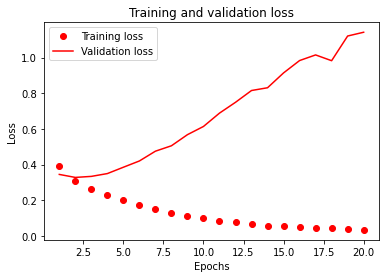

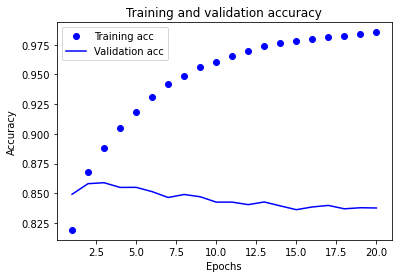

In [262]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()   # 그림을 초기화한다.

# "bo"는 "파란색 점"이다.
plt.plot(epochs, acc, 'bo', label='Training acc')
# b는 "파란 실선"이다.
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 4-2-4. 테스트 평가

In [37]:
results = model1.evaluate(X_test, y_test, verbose=2)

print(results)

1516/1516 - 5s - loss: 1.2475 - accuracy: 0.8355 - 5s/epoch - 3ms/step
[1.247511386871338, 0.8354571461677551]


#### 4-3-1. 1-D CNN 모델

In [41]:
vocab_size = 10000  # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(32,7,activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(32,7,activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(16, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 이다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2000000   
                                                                 
 conv1d (Conv1D)             (None, None, 32)          44832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 16)               

#### 4-3-2. 1-D CNN 모델 훈련

In [42]:
# 학습 환경 설정
model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

epochs = 20

history = model2.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     validation_data=(X_valid, y_valid),
                     verbose=1)

Epoch 1/20
3597/3597 [==============================] - 36s 8ms/step - loss: 0.4416 - accuracy: 0.7818 - val_loss: 0.4012 - val_accuracy: 0.8112
Epoch 2/20
3597/3597 [==============================] - 29s 8ms/step - loss: 0.3345 - accuracy: 0.8461 - val_loss: 0.4207 - val_accuracy: 0.8065
Epoch 3/20
3597/3597 [==============================] - 30s 8ms/step - loss: 0.2407 - accuracy: 0.8920 - val_loss: 0.4666 - val_accuracy: 0.7989
Epoch 4/20
3597/3597 [==============================] - 26s 7ms/step - loss: 0.1733 - accuracy: 0.9215 - val_loss: 0.5633 - val_accuracy: 0.7961
Epoch 5/20
3597/3597 [==============================] - 19s 5ms/step - loss: 0.1369 - accuracy: 0.9375 - val_loss: 0.6718 - val_accuracy: 0.7914
Epoch 6/20
3597/3597 [==============================] - 18s 5ms/step - loss: 0.1147 - accuracy: 0.9460 - val_loss: 0.7717 - val_accuracy: 0.7900
Epoch 7/20
3597/3597 [==============================] - 19s 5ms/step - loss: 0.1013 - accuracy: 0.9519 - val_loss: 0.8934 - val_ac

#### 4-3-3. Loss, Accuracy 그래프 시각화

In [43]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


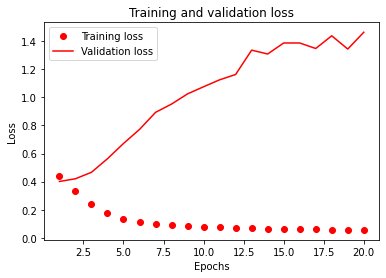

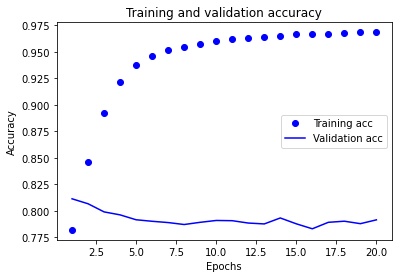

In [48]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 4-3-4. 테스트 평가

In [49]:
# test 결과
results = model2.evaluate(X_test, y_test, verbose=2)
print(results)

1516/1516 - 4s - loss: 1.4447 - accuracy: 0.7850 - 4s/epoch - 3ms/step
[1.444684624671936, 0.7850427031517029]


#### 4-4-1. GlobalMaxPooling1D() 레이어 1개 모델

In [53]:
vocab_size = 10000
word_vector_dim = 200

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(16, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         2000000   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 16)                3216      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,003,233
Trainable params: 2,003,233
Non-trainable params: 0
_________________________________________________________________


#### 4-4-2. GlobalMaxPooling1D() 모델 훈련

In [55]:
# 학습 환경 설정
model3.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

epochs = 20

history = model3.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=256,
                     validation_data=(X_valid, y_valid),
                     verbose=1)

# verbose는 학습의 진행 상황을 보여줄 것인지 지정을 하는데 verbose를 1로 세팅하면 학습이 되는 모습을 볼 수 있다.

Epoch 1/20
450/450 [==============================] - 4s 8ms/step - loss: 0.4245 - accuracy: 0.8124 - val_loss: 0.3496 - val_accuracy: 0.8470
Epoch 2/20
450/450 [==============================] - 3s 7ms/step - loss: 0.3005 - accuracy: 0.8740 - val_loss: 0.3442 - val_accuracy: 0.8524
Epoch 3/20
450/450 [==============================] - 3s 7ms/step - loss: 0.2479 - accuracy: 0.9007 - val_loss: 0.3565 - val_accuracy: 0.8503
Epoch 4/20
450/450 [==============================] - 3s 7ms/step - loss: 0.1962 - accuracy: 0.9255 - val_loss: 0.3899 - val_accuracy: 0.8438
Epoch 5/20
450/450 [==============================] - 3s 7ms/step - loss: 0.1447 - accuracy: 0.9492 - val_loss: 0.4297 - val_accuracy: 0.8437
Epoch 6/20
450/450 [==============================] - 3s 7ms/step - loss: 0.0972 - accuracy: 0.9691 - val_loss: 0.4873 - val_accuracy: 0.8407
Epoch 7/20
450/450 [==============================] - 3s 7ms/step - loss: 0.0627 - accuracy: 0.9816 - val_loss: 0.5625 - val_accuracy: 0.8365
Epoch 

#### 4-4-3. GlobalMaxPooling1D() 모델 훈련

In [58]:
history_dict=history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


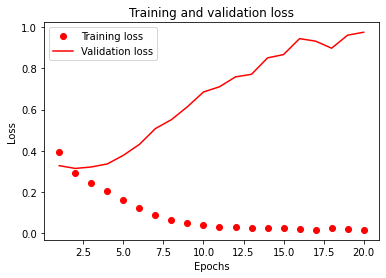

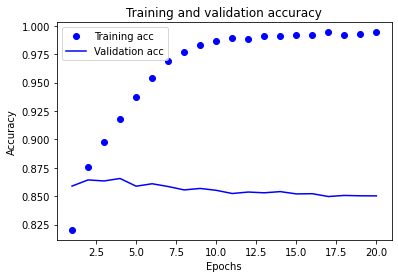

In [97]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 4-4-4. 테스트 평가

In [60]:
# test 결과
results = model3.evaluate(X_test, y_test, verbose=2)
print(results)

1516/1516 - 4s - loss: 1.2033 - accuracy: 0.8297 - 4s/epoch - 2ms/step
[1.2033262252807617, 0.8297455310821533]


### 5. 학습된 Embedding 레이어 분석

In [61]:
# 단어의 특성을 저차원 벡터값으로 표현할 수 있는 워드 임베딩(word embedding) 기법
embedding_layer = model1.layers[0]  # GRU로 학습된 모델을 대상으로 분석
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 200)


In [65]:
import os
from gensim import models  # gensim : 워드벡터를 다루는데 유용한 패키지

# 학습한 Embedding 파라미터 파일에 써서 저장한다.
word2vec_file_path = '/content/drive/MyDrive/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다.

# 단어 개수(툭수문자 4개 제외)만큼의 워드 벡터를 파일에 기록한다.
vectors = model2.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [66]:
# 임베딩 파라미터를 읽어서 word vector로 활용
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.16362952, -0.12624125,  0.00360623,  0.18292579,  0.05774087,
        0.15795624, -0.00607039, -0.16173637,  0.32523558, -0.11305905,
        0.08704822, -0.32016635,  0.06334891,  0.07566755,  0.03210901,
        0.30952215, -0.06550916, -0.01803346, -0.12573326, -0.21421693,
        0.15513657,  0.01664898,  0.02078858,  0.03093729,  0.00548134,
        0.18640698, -0.12905788, -0.07998336,  0.09045084, -0.1317727 ,
        0.11098628, -0.21025914, -0.07092556, -0.06073579,  0.08315822,
       -0.00524681,  0.28950915, -0.06595908,  0.21363118, -0.08702177,
        0.21651064, -0.13964659, -0.03015615,  0.07460336,  0.1440387 ,
       -0.02711013,  0.0092336 ,  0.2056105 , -0.19691555,  0.00384474,
       -0.30575028,  0.01703158,  0.15138601,  0.04528848,  0.03344517,
       -0.17578232,  0.07079928,  0.03717942, -0.014743  ,  0.09109084,
       -0.12757322, -0.15691869,  0.15440913,  0.01750032,  0.06615106,
        0.02219159,  0.10715371, -0.33640483,  0.44301367, -0.09

In [67]:
# 단어를 하나 주고 가장 유사한 단어와 유사도 확ㅇ니
word_vectors.similar_by_word("영화")

[('였', 0.4502096176147461),
 ('쉬', 0.4076431095600128),
 ('철철', 0.37729862332344055),
 ('영상', 0.36559951305389404),
 ('기대', 0.34841200709342957),
 ('애니', 0.3369067907333374),
 ('겪', 0.33687397837638855),
 ('줄줄이', 0.3361671566963196),
 ('흔하', 0.33497095108032227),
 ('추노', 0.33430567383766174)]

### 6. 한국어 Word2Vec 임베딩 활용하여 성능 개선

#### 6-1. 사전에 학습된 Word2Vec 등의 임베딩 모델(ko.bin)을 활용하는 전이학습(Transfer Learning)

In [174]:
!pip install --upgrade gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [175]:
# 한국어 Word2Vec 임베딩 활용한 성능 개선
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [176]:
word2vec_path = '/content/drive/MyDrive/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
# word2vec = gensim.models.Word2vec.load(word2vec_path)  # 학습한 모델 로드

# 완성된 임베딩 매트릭스의 크기 확인
print(word2vec.wv.vectors.shape)

(30185, 200)


In [184]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [185]:
# LSTM 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen,
                                 trainable=True))
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 48, 200)           2000000   
                                                                 
 lstm_5 (LSTM)               (None, 128)               168448    
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [187]:
# 학습의 진행
model.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

epochs = 7

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_valid, y_valid),
                    verbose=1)

Epoch 1/7
1799/1799 [==============================] - 31s 14ms/step - loss: 0.3497 - accuracy: 0.8460 - val_loss: 0.3279 - val_accuracy: 0.8573
Epoch 2/7
1799/1799 [==============================] - 13s 7ms/step - loss: 0.2830 - accuracy: 0.8794 - val_loss: 0.3180 - val_accuracy: 0.8631
Epoch 3/7
1799/1799 [==============================] - 13s 7ms/step - loss: 0.2398 - accuracy: 0.9006 - val_loss: 0.3281 - val_accuracy: 0.8602
Epoch 4/7
1799/1799 [==============================] - 14s 8ms/step - loss: 0.1971 - accuracy: 0.9211 - val_loss: 0.3441 - val_accuracy: 0.8642
Epoch 5/7
1799/1799 [==============================] - 13s 7ms/step - loss: 0.1555 - accuracy: 0.9387 - val_loss: 0.3760 - val_accuracy: 0.8614
Epoch 6/7
1799/1799 [==============================] - 13s 7ms/step - loss: 0.1172 - accuracy: 0.9556 - val_loss: 0.4620 - val_accuracy: 0.8491
Epoch 7/7
1799/1799 [==============================] - 13s 7ms/step - loss: 0.0869 - accuracy: 0.9680 - val_loss: 0.5174 - val_accuracy

In [188]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


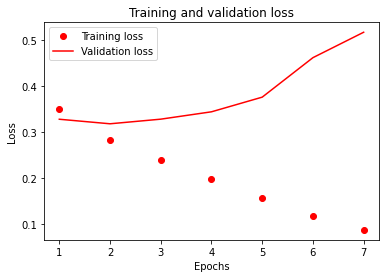

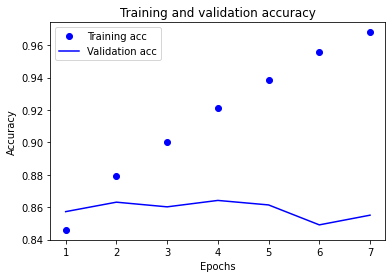

In [189]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [190]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1516/1516 - 4s - loss: 0.5209 - accuracy: 0.8541 - 4s/epoch - 3ms/step
[0.520922839641571, 0.8540970683097839]


In [192]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

* Model1 : LSTM

In [227]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 200)


In [228]:
# 학습한 Embedding 파라미터를 파일에 써서 저장한다.
word2vec_file_path = '/content/drive/MyDrive/sentiment_classification/word2vec_RNN.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) ## 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 쓴다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록한다.
vectors = model1.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [229]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.01168726,  0.084478  , -0.03435707, -0.14456421,  0.11584412,
       -0.0623613 ,  0.02968056,  0.0035247 , -0.00081615, -0.02635366,
        0.09200995, -0.02885733,  0.07483369,  0.05842755,  0.14410357,
       -0.06357124,  0.01956436, -0.09142468,  0.04631441,  0.09238229,
       -0.02338261, -0.07702272,  0.03961678,  0.18518108, -0.07855587,
        0.03761779, -0.10295548,  0.08172774, -0.09536225, -0.1761319 ,
       -0.05258565,  0.01893044,  0.17626697,  0.03358863, -0.00566478,
        0.16170669,  0.08972184,  0.0146762 , -0.01849752, -0.11638485,
        0.08677456,  0.13255131,  0.09273788, -0.11138216, -0.14701593,
        0.00308576,  0.00799491,  0.02130159,  0.02406064,  0.05636022,
       -0.0406412 , -0.05491825,  0.10323472, -0.20824265,  0.12974639,
        0.04692316,  0.06462281,  0.2099775 ,  0.01698889, -0.01880853,
       -0.18794109,  0.0051532 , -0.02482496, -0.02279401, -0.06717815,
       -0.00375752,  0.05087723, -0.06015732,  0.06746443, -0.01

In [230]:
word_vectors.similar_by_word("재미")

[('잼', 0.5726073384284973),
 ('몸짓', 0.5283682346343994),
 ('닿', 0.5276622772216797),
 ('재밌', 0.5275838971138),
 ('최', 0.5268248915672302),
 ('예수', 0.5210540294647217),
 ('차원', 0.5148540735244751),
 ('브로디', 0.5129058361053467),
 ('어릴', 0.5067381858825684),
 ('대해', 0.50508713722229)]

In [231]:
word_vectors.similar_by_word("행복")

[('느끼', 0.6846579313278198),
 ('슬프', 0.6638926267623901),
 ('신기', 0.6343170404434204),
 ('느껴', 0.6225070953369141),
 ('경의', 0.6221129894256592),
 ('최신', 0.6142946481704712),
 ('멋지', 0.6098209619522095),
 ('빠져', 0.6090795993804932),
 ('세세', 0.6036957502365112),
 ('대박', 0.6033415198326111)]

In [232]:
word_vectors.similar_by_word("따뜻")

[('최', 0.654693603515625),
 ('산다는', 0.6249358654022217),
 ('월요일', 0.620259165763855),
 ('주일', 0.6133925914764404),
 ('재미있', 0.6125873327255249),
 ('묶', 0.6044560670852661),
 ('해설', 0.5890375375747681),
 ('치즈', 0.5817951560020447),
 ('통해', 0.5815732479095459),
 ('묵직', 0.5811116099357605)]

In [233]:
word_vectors.similar_by_word("최악")

[('지겨워서', 0.8643180727958679),
 ('무분별', 0.8605042695999146),
 ('반말', 0.8600190877914429),
 ('열중', 0.8579766750335693),
 ('문란', 0.8514608144760132),
 ('허접쓰레기', 0.8496911525726318),
 ('거려', 0.849132776260376),
 ('저랬', 0.8480046987533569),
 ('순이', 0.8459312915802002),
 ('본데', 0.8456572890281677)]

In [234]:
word_vectors.similar_by_word("슬픔")

[('뜻밖', 0.7688899040222168),
 ('데이즈', 0.7521281242370605),
 ('더욱', 0.7515940070152283),
 ('오컬트', 0.7478286027908325),
 ('검프', 0.745078444480896),
 ('훈훈', 0.7425708770751953),
 ('지리', 0.7398726344108582),
 ('빼놓', 0.7389023303985596),
 ('낯선', 0.7377039790153503),
 ('고대', 0.7352944612503052)]

In [235]:
word_vectors.similar_by_word("우울")

[('어쩌', 0.6683464050292969),
 ('그러나', 0.5347463488578796),
 ('연예인', 0.4649119973182678),
 ('아무렇', 0.46377676725387573),
 ('주년', 0.456747442483902),
 ('다수', 0.45656558871269226),
 ('4', 0.45126616954803467),
 ('그냥', 0.42980578541755676),
 ('라고', 0.4250507354736328),
 ('거리', 0.4241827428340912)]

In [236]:
word_vectors.similar_by_word("분노")

[('못', 0.7084090113639832),
 ('데스', 0.6951520442962646),
 ('임무', 0.6941906213760376),
 ('깨', 0.6903679370880127),
 ('깎', 0.6880708932876587),
 ('게스트', 0.6867116689682007),
 ('라며', 0.6860117316246033),
 ('접', 0.6772372722625732),
 ('금포', 0.6698756217956543),
 ('세월', 0.6698032021522522)]

* 한국어 Word2Vec 임베딩을 활용한 Model : LSTM

In [252]:
word2vec.wv.most_similar("재미")

[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [253]:
word2vec.wv.most_similar("행복")

[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [254]:
word2vec.wv.most_similar("따뜻")

[('깨끗', 0.8110603094100952),
 ('시원', 0.7888997793197632),
 ('온화', 0.7739460468292236),
 ('차갑', 0.7733761072158813),
 ('서늘', 0.7700977921485901),
 ('조용', 0.7690449357032776),
 ('잔잔', 0.7158679962158203),
 ('편안', 0.7051763534545898),
 ('덥', 0.7028454542160034),
 ('딱딱', 0.6989432573318481)]

In [255]:
word2vec.wv.most_similar("최악")

[('초유', 0.546215832233429),
 ('최대', 0.4657382071018219),
 ('대공황', 0.4530748426914215),
 ('최고', 0.4529539942741394),
 ('최장', 0.4382264018058777),
 ('역전', 0.43632203340530396),
 ('최하위', 0.42039841413497925),
 ('여파', 0.4164554476737976),
 ('불황', 0.4069921672344208),
 ('추돌', 0.40534573793411255)]

In [256]:
word2vec.wv.most_similar("슬픔")

[('기쁨', 0.7767106294631958),
 ('절망', 0.7710496783256531),
 ('아픔', 0.7430999279022217),
 ('비탄', 0.7297681570053101),
 ('고독', 0.7251476049423218),
 ('사랑', 0.7216662168502808),
 ('외로움', 0.7195188999176025),
 ('추억', 0.6951203346252441),
 ('이별', 0.6873862147331238),
 ('괴로움', 0.6854110956192017)]

In [257]:
word2vec.wv.most_similar("우울")

[('강렬', 0.6977053880691528),
 ('무기력', 0.6428703665733337),
 ('애절', 0.6334070563316345),
 ('경쾌', 0.6156872510910034),
 ('예리', 0.6113821268081665),
 ('추악', 0.6113097071647644),
 ('비통', 0.6093991994857788),
 ('일그러지', 0.6051713228225708),
 ('차분', 0.5982251167297363),
 ('침착', 0.5927936434745789)]

In [258]:
word2vec.wv.most_similar("분노")

[('격노', 0.7377745509147644),
 ('격분', 0.7231990694999695),
 ('원망', 0.721239447593689),
 ('분개', 0.6994378566741943),
 ('질투', 0.6872379183769226),
 ('실망', 0.6750859022140503),
 ('당황', 0.6650348901748657),
 ('증오', 0.6568769216537476),
 ('경악', 0.6351868510246277),
 ('반발', 0.6297549605369568)]

* LSTM 모델과 임베딩을 활용한 LSTM 모델을 비교하면서 유사 단어 찾기를 진행하였다. 그 결과, 전반적으로 두 모델이 유사 단어 찾기를 잘 수행한 것으로 보인다. 그래도 두 모델 사이에서 특정 단어마다 잘 찾아내는 정도의 차이를 확인할 수 있다.

# ✍ 회고

* 루브릭 평가기준을 위한 발자취...

  이정도면 나름 빨리 원하는 결과가 나왔다고 생각한다. 나이쓰~
epoch 값이 너무 작으면 underfitting, 너무 크면 overfitting이 발생할 확률이 높다. 과적합을 해결하기 위해 early stopping을 사용하는 방법도 있다. 단어 그대로 '조기 종료'라는 뜻으로 이전 epoch 때와 비교해서 오차가 증가했다면 학습을 중단한다(과적합 되는 모델의 경우, epoch가 커질수록 val_loss가 줄어들다가 다시 늘게 되는 경우가 생기는데 이때 학습을 종료시켜주는 콜백함수이다). early stopping을 안써서 아주 조금 아쉽지만, 다음에 쓸 기회가 있으면 시도해보겠다.

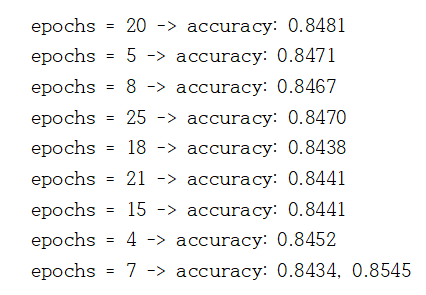

*  batch(보통 mini-batch라고 부름) 는 나눠진 데이터 셋을 의미한다. 예를 들어, 700개의 이미지로 이뤄진 데이터셋이있는데, 우리가 7번에 걸쳐서 학습시킨다면 7개의 배치를 만들어서 학습시킨다.

* LSTM, 1-D CNN, GlobalMaxPooling 1D로 모델을 선정하여 프로젝트를 진행하였다. 마지막에 유사 단어 찾기 부분에서 각 모델마다 '재미, 행복, 따뜻, 최악, 슬픔, 우울, 분노'를 비교해보려고 했다. 그래서 거의 90% 정도 마무리하고 있는 와중에 전체적인 결과를 확인해보니 각 모델마다 해당 단어의 값들이 달라야 하는데 하나로 동일했다. 코드에서 문제가 있었을텐데... 고민을 하다가 정신건강에 이로운 길을 택하여 대표 모델 하나만 출력했다... 다음에 더 열심히 해봐야겠다.

* RNN과 LSTM의 차이를 정확히 인지하지 못해서 조금 찾아봤다. 이 문제 때문에 익스를 진행하는 과정에서 시간을 더 투자한 경향이 없지않아 많.았.다. RNN (Recurrent Neural Networks 순환신경망)은 인공신경망의 한 종류로, 유닛간의 연결이 순환적 구조를 갖는 특징을 갖고 있다. 이러한 구조는 시변적(시간에 따라 변하는) 동적 특징을 모델링 할 수 있도록 신경망 내부에 상태를 저장할 수 있게 해준다.LSTM (Long Short Term Memory)은 딥러닝 분야에서 사용되는 RNN 아키텍처다. 표준의 Feed-Forward 신경망과 달리 LSTM은 피드백연결을 가지고 있다. 장기 메모리와 단기 메모리에 들어갈 정보를 나눠 학습한다.

 * RNN은 단기기억이 존재하고, LSTM은 단기기억과 장기기억이 모두 존재한다. 단기기억뿐인 RNN을 보완하여 장기와 단기로 나누어서 정보를 전달하는 LSTM의 구조가 더욱 정교하다. LSTM은 순차데이터를 처리할 때 입력의 길이가 길어져도 이전 정보를 더 오래 기억하므로 RNN보다 더 성능이 좋다. 즉, LSTM은 RNN보다 발전된 형태의 순환신경망이다.

* 이번 익스는 전체적으로 필사를 했다. 양심이 많이 찔리는 익스였다... 약간의 흐름은 알겠는데, 완전히 이해했다고 할 수는 없다. 이 또한 남은 나의 숙제이다...

  익스를 하면서 부족함이 많다는 걸 더욱 느꼈다. 그래도 제출해야겠다. 정신건강을 위하여 익스를 빨리 끝내려고 한다. 다음에 더 분발해야겠다!

**🔆 참고자료**

* https://github.com/yenaryu/AI/blob/main/%5BE-06%5Dmovie%20reivew%20sentiment.ipynb